# Pretrained 3D ResNet as feature extractor (30 animal classes)

In [ ]:
#%%python3 -m pip install --upgrade pip

In [3]:
!pip install mediapipe=='0.10.9'
!pip install opencv-python=='4.8.0.76'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 33.8 MB/s eta 0:00:00


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
from utils import VideoDataset, validate_model, train_model, display_frames, display_learning_dynamic, classification_model_metrics

In [5]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import json

In [40]:
def save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic):
    with open(f'{save_path}/{model_name}_loss_acc_dynamic.json', 'w') as f:
        json.dump(
            {
                'train_loss_dynamic': train_loss_dynamic,
                'val_accuracy_dynamic': val_accuracy_dynamic
            },
            f)

In [35]:
use_cuda = True
seed = 1

train_batch_size = 1
test_batch_size = 1
val_batch_size = 1
IMG_SIZE = 112

limit_list = [] #["динозавр", "пингвин", "кролик"]

min_frame_count = 25

lr = 0.0001
momentum = 0.0001
epoches = 15
save = True

annotations_file = "/content/drive/MyDrive/slovo/SLOVO_DF_SHORT.tsv" #"/home/jupyter/mnt/s3/rsl-videos/slovo/slovo_annotations/SLOVO_DATAFRAME.tsv"
dataloader_dir = "/content/drive/MyDrive/slovo/dataloaders/"

save_path = '/content/drive/MyDrive/slovo/models' #'/content/model'
model_name = 'ResNet_r3d_18_transferFE_Kinetics400'

In [16]:
video_labels = pd.read_csv(annotations_file, sep='\t')
video_labels['group_rank'] = video_labels.groupby(['text']).cumcount()+1;
video_labels['dataset'] = np.where(video_labels['group_rank']<17,'train', np.where(video_labels['group_rank']<19,'val', 'test'))
if len(limit_list)>0:
  video_labels = video_labels[video_labels.text.isin(limit_list)]
video_labels.tail(5)

,Unnamed: 0,attachment_id,text,begin,end,group_rank,dataset
595,55,25b5fb58-46dd-4fd6-9928-734460795b22,мышь,22,83,20,test
596,56,336e0e7a-ff68-427c-9a77-52626b81edd1,паук,42,74,19,test
597,57,d0ec4c00-6ff5-4089-ac9d-5a33a76fb037,паук,3,70,20,test
598,58,59ae408b-f87a-422a-bc57-2ff5af28ee57,бабочка,2,74,19,test
599,59,e421d77c-1dcd-4124-b2a4-b2415569a4dd,бабочка,63,131,20,test


In [17]:
classes = tuple(video_labels.text.unique())
n_class = len(classes)
print(f"Total number of classes: {n_class}. Example classes: {classes[:5]}")

Total number of classes: 30. Example classes: ('пингвин', 'жираф', 'лягушка', 'бегемот', 'козел')


In [18]:
classes.index('пингвин')

0

In [10]:
train_dataloader = torch.load(dataloader_dir + 'color_frames_train_dataloader.pth')
print(f"Train dataloader contains: {len(train_dataloader)} videos")
val_dataloader = torch.load(dataloader_dir + 'color_frames_val_dataloader.pth')
print(f"Val dataloader contains: {len(val_dataloader)} videos")
test_dataloader = torch.load(dataloader_dir + 'color_frames_test_dataloader.pth')
print(f"Test dataloader contains: {len(test_dataloader)} videos")

Train dataloader contains: 480 videos
Val dataloader contains: 60 videos
Test dataloader contains: 60 videos


In [21]:
use_cuda = use_cuda and torch.cuda.is_available()

if use_cuda:
  for dl in [train_dataloader, val_dataloader, test_dataloader]:
    dl.num_workers = 0
    dl.pin_memory = True
  torch.cuda.manual_seed(seed)  # Set the random seed for the current GPU
else:
  torch.manual_seed(seed)

device = torch.device("cuda" if use_cuda else "cpu")

print(f"Device: {device}")

Device: cuda


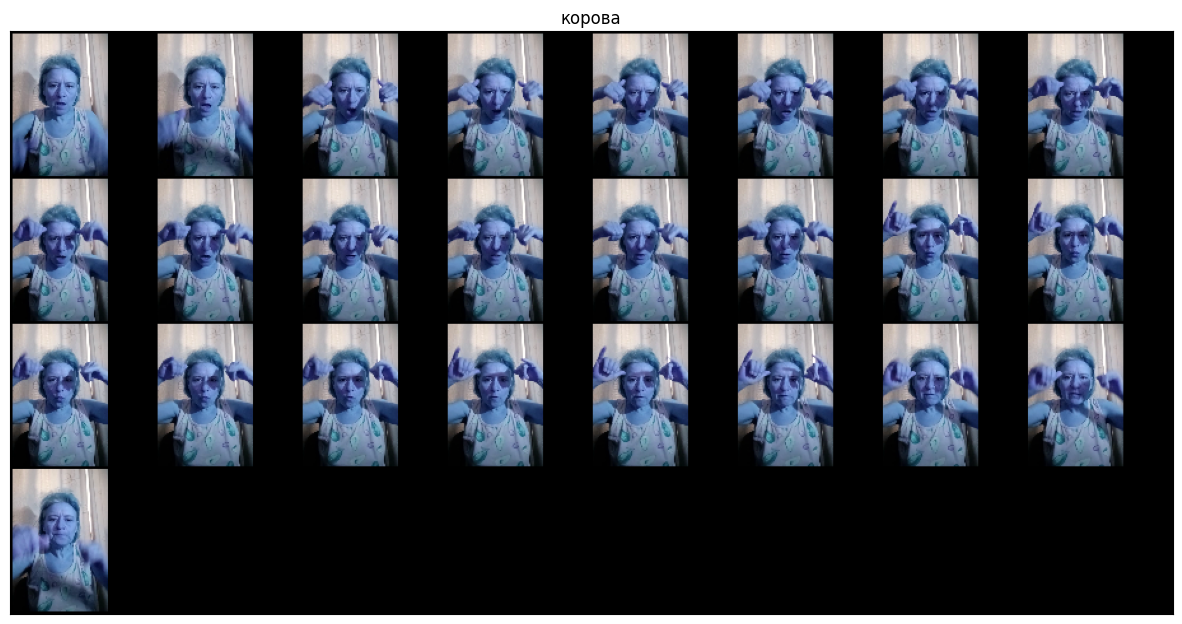

In [19]:
display_frames(n_frames=1, dataloader=train_dataloader, classes=classes)

In [22]:
frames, labels = next(iter(test_dataloader))
print(f"Frames shape: {frames.shape}") # (batch_size, -channels, frames, w, h) torch.Size([1, 3, 25, 112, 112])
print(f"Labels shape: {labels.shape}") # batch_size
print(f"Labels: {labels}") # class index

Frames shape: torch.Size([1, 3, 25, 112, 112])
Labels shape: torch.Size([1])
Labels: tensor([20])


In [23]:
resnet = torchvision.models.video.r3d_18(weights='KINETICS400_V1')
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features
resnet.fc = nn.Linear(num_ftrs, n_class) # reset out features fir the last layer to the number of classes
resnet.fc

Downloading: "https://download.pytorch.org/models/r3d_18-b3b3357e.pth" to /root/.cache/torch/hub/checkpoints/r3d_18-b3b3357e.pth
100%|██████████| 127M/127M [00:01<00:00, 76.0MB/s]


Linear(in_features=512, out_features=30, bias=True)

In [24]:
print(resnet)

VideoResNet(
  (stem): BasicStem(
    (0): Conv3d(3, 64, kernel_size=(3, 7, 7), stride=(1, 2, 2), padding=(1, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
      (conv2): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU(inplace=True)
    )
    (1): BasicBlock(
      (conv1): Sequential(
        (0): Conv3DSimple(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (1):

In [27]:
# Print trainable parameters
for name, param in resnet.named_parameters():
    if param.requires_grad:
        print(name, param.data)

fc.weight tensor([[ 0.0393,  0.0438, -0.0163,  ..., -0.0171, -0.0413,  0.0216],
        [ 0.0015, -0.0287, -0.0120,  ..., -0.0421, -0.0079, -0.0327],
        [ 0.0020, -0.0314,  0.0267,  ..., -0.0248, -0.0037, -0.0157],
        ...,
        [-0.0113,  0.0023, -0.0269,  ...,  0.0250, -0.0303,  0.0199],
        [-0.0402,  0.0008,  0.0400,  ...,  0.0268,  0.0405, -0.0168],
        [-0.0054,  0.0140, -0.0205,  ..., -0.0256, -0.0031, -0.0182]])
fc.bias tensor([ 0.0034,  0.0044, -0.0304,  0.0341,  0.0016, -0.0069, -0.0176,  0.0361,
        -0.0177,  0.0017, -0.0006, -0.0322,  0.0021,  0.0074, -0.0441, -0.0002,
         0.0043, -0.0417, -0.0280, -0.0024,  0.0117, -0.0397,  0.0349,  0.0171,
         0.0375,  0.0398, -0.0386,  0.0378, -0.0399,  0.0307])


In [28]:
frames, labels = next(iter(test_dataloader))
frames = frames.to(device)
resnet.to(device)
print(f"Output shape: {resnet(frames/255).shape}") # batch size, number of classes

Output shape: torch.Size([1, 30])


In [29]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet.parameters(), lr=lr)

In [30]:
def check_some_predictions(n, model):
  test_dl = iter(test_dataloader)
  for i in range(n):
    frames, labels = next(test_dl)
    frames=frames.to(device)
    true_label = classes[labels.item()]
    output = model(frames/255)
    pred_label = classes[torch.argmax(output, 1)]
    print(f"Label: {true_label}; Predicted: {pred_label}")
check_some_predictions(4, resnet)

Label: лягушка; Predicted: птица
Label: мышь; Predicted: птица
Label: орел; Predicted: птица
Label: лев; Predicted: птица


In [31]:
best_acc = 1/n_class

previous_epochs = 0
num_epoches = 15

if use_cuda:
  model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
  cudnn.benchmark = True

epochs = list()
train_loss_dynamic = list()
val_accuracy_dynamic = list()
for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)
    check_some_predictions(4, resnet)

Train Epoch 1/15: train_loss=3.5288; val acc=0.067
Label: пчела; Predicted: змея
Label: курица; Predicted: жираф
Label: лебедь; Predicted: лягушка
Label: лось; Predicted: змея
Train Epoch 2/15: train_loss=3.4611; val acc=0.033
Label: лось; Predicted: бык
Label: лось; Predicted: лиса
Label: лиса; Predicted: бык
Label: лебедь; Predicted: бык
Train Epoch 3/15: train_loss=3.3126; val acc=0.100
Label: корова; Predicted: орел
Label: слон; Predicted: курица
Label: пингвин; Predicted: слон
Label: птица; Predicted: змея
Train Epoch 4/15: train_loss=3.1758; val acc=0.083
Label: медуза; Predicted: пингвин
Label: слон; Predicted: бык
Label: паук; Predicted: курица
Label: змея; Predicted: бык
Train Epoch 5/15: train_loss=3.0586; val acc=0.133
Label: слон; Predicted: медуза
Label: собака; Predicted: паук
Label: жираф; Predicted: лось
Label: курица; Predicted: лягушка
Train Epoch 6/15: train_loss=2.9566; val acc=0.117
Label: павлин; Predicted: лебедь
Label: обезьяна; Predicted: птица
Label: лось; Pre

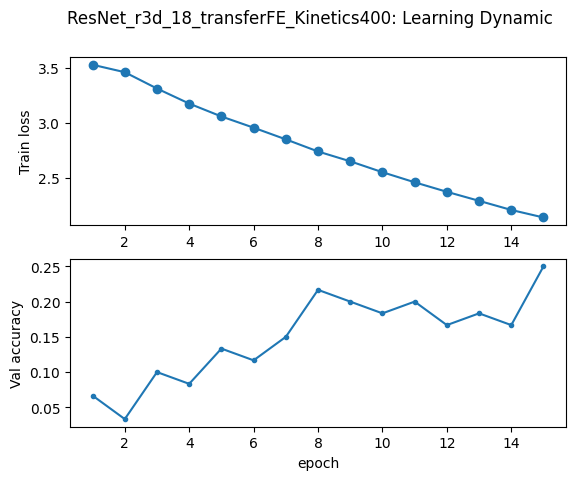

In [33]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [41]:
#best_acc = 1/n_class

previous_epochs = 15
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)
    check_some_predictions(4, resnet)

Train Epoch 16/15: train_loss=2.0734; val acc=0.217
Label: жираф; Predicted: жираф
Label: павлин; Predicted: павлин
Label: слон; Predicted: обезьяна
Label: птица; Predicted: орел
Train Epoch 17/15: train_loss=1.9979; val acc=0.250
Label: лягушка; Predicted: лягушка
Label: медведь; Predicted: обезьяна
Label: курица; Predicted: собака
Label: лев; Predicted: динозавр
Train Epoch 18/15: train_loss=1.9339; val acc=0.233
Label: лягушка; Predicted: лягушка
Label: тигр; Predicted: паук
Label: змея; Predicted: обезьяна
Label: орел; Predicted: обезьяна
Train Epoch 19/15: train_loss=1.8649; val acc=0.200
Label: обезьяна; Predicted: обезьяна
Label: бабочка; Predicted: бабочка
Label: змея; Predicted: змея
Label: медведь; Predicted: обезьяна
Train Epoch 20/15: train_loss=1.8068; val acc=0.217
Label: бабочка; Predicted: обезьяна
Label: свинья; Predicted: собака
Label: тигр; Predicted: паук
Label: змея; Predicted: обезьяна
Train Epoch 21/15: train_loss=1.7444; val acc=0.217
Label: свинья; Predicted: м

In [ ]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

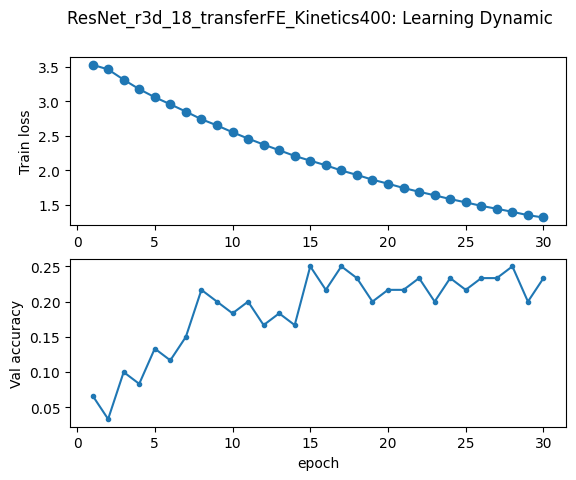

In [42]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [43]:
#best_acc = 1/n_class

previous_epochs = 30
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 31/45: train_loss=1.2706; val acc=0.233
Train Epoch 32/45: train_loss=1.2391; val acc=0.183
Train Epoch 33/45: train_loss=1.2022; val acc=0.250
Train Epoch 34/45: train_loss=1.1646; val acc=0.183
Train Epoch 35/45: train_loss=1.1218; val acc=0.250
Train Epoch 36/45: train_loss=1.097; val acc=0.233
Train Epoch 37/45: train_loss=1.0619; val acc=0.217
Train Epoch 38/45: train_loss=1.0329; val acc=0.217
Train Epoch 39/45: train_loss=1.0002; val acc=0.217
Train Epoch 40/45: train_loss=0.9755; val acc=0.233
Train Epoch 41/45: train_loss=0.9392; val acc=0.200
Train Epoch 42/45: train_loss=0.9171; val acc=0.217
Train Epoch 43/45: train_loss=0.89; val acc=0.217
Train Epoch 44/45: train_loss=0.8626; val acc=0.233
Train Epoch 45/45: train_loss=0.839; val acc=0.250


In [44]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

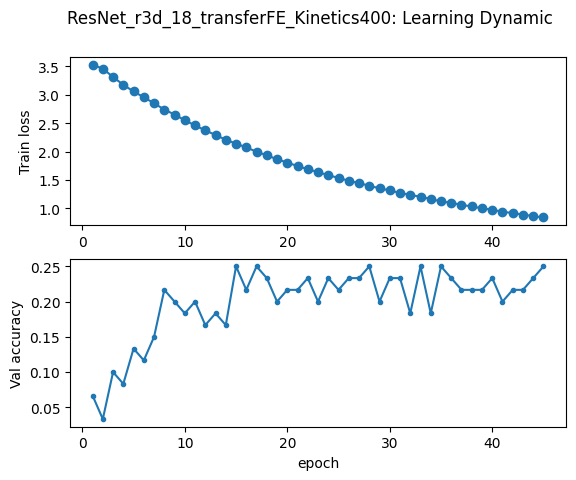

In [45]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [46]:
#best_acc = 1/n_class

previous_epochs = 45
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 46/60: train_loss=0.8171; val acc=0.233
Train Epoch 47/60: train_loss=0.7862; val acc=0.233
Train Epoch 48/60: train_loss=0.7677; val acc=0.217
Train Epoch 49/60: train_loss=0.7497; val acc=0.250
Train Epoch 50/60: train_loss=0.722; val acc=0.217
Train Epoch 51/60: train_loss=0.7025; val acc=0.233
Train Epoch 52/60: train_loss=0.6846; val acc=0.200
Train Epoch 53/60: train_loss=0.6675; val acc=0.250
Train Epoch 54/60: train_loss=0.6507; val acc=0.217
Train Epoch 55/60: train_loss=0.6271; val acc=0.233
Train Epoch 56/60: train_loss=0.6118; val acc=0.217
Train Epoch 57/60: train_loss=0.5908; val acc=0.217
Train Epoch 58/60: train_loss=0.5709; val acc=0.200
Train Epoch 59/60: train_loss=0.5614; val acc=0.200
Train Epoch 60/60: train_loss=0.5438; val acc=0.183


In [47]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

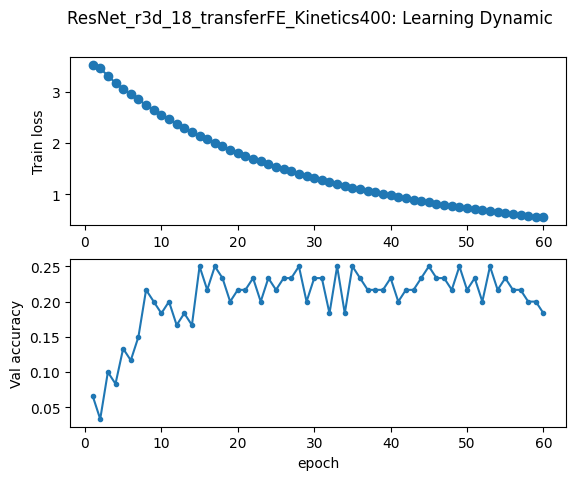

In [48]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [49]:
#best_acc = 1/n_class

previous_epochs = 60
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 61/75: train_loss=0.5308; val acc=0.217
Train Epoch 62/75: train_loss=0.5153; val acc=0.233
Train Epoch 63/75: train_loss=0.4963; val acc=0.217
Train Epoch 64/75: train_loss=0.4893; val acc=0.233
Train Epoch 65/75: train_loss=0.4681; val acc=0.183
Train Epoch 66/75: train_loss=0.458; val acc=0.200
Train Epoch 67/75: train_loss=0.4466; val acc=0.217
Train Epoch 68/75: train_loss=0.4305; val acc=0.217
Train Epoch 69/75: train_loss=0.421; val acc=0.183
Train Epoch 70/75: train_loss=0.4074; val acc=0.250
Train Epoch 71/75: train_loss=0.397; val acc=0.217
Train Epoch 72/75: train_loss=0.3824; val acc=0.217
Train Epoch 73/75: train_loss=0.3764; val acc=0.200
Train Epoch 74/75: train_loss=0.3645; val acc=0.233
Train Epoch 75/75: train_loss=0.3563; val acc=0.200


In [50]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

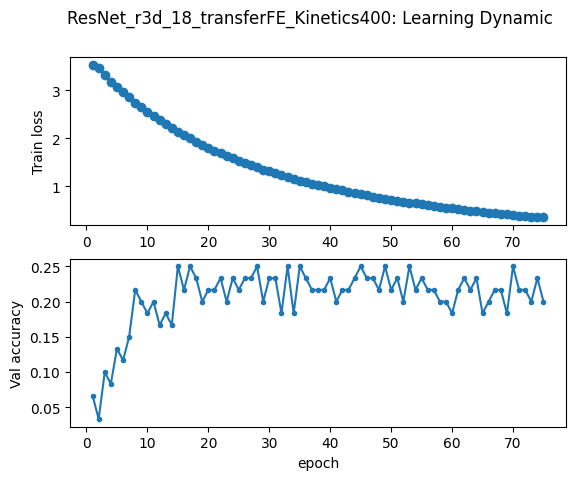

In [51]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [52]:
#best_acc = 1/n_class

previous_epochs = 75
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 76/90: train_loss=0.3439; val acc=0.200
Train Epoch 77/90: train_loss=0.3333; val acc=0.200
Train Epoch 78/90: train_loss=0.3256; val acc=0.217
Train Epoch 79/90: train_loss=0.3142; val acc=0.200
Train Epoch 80/90: train_loss=0.3067; val acc=0.200
Train Epoch 81/90: train_loss=0.3007; val acc=0.217
Train Epoch 82/90: train_loss=0.2911; val acc=0.233
Train Epoch 83/90: train_loss=0.2807; val acc=0.233
Train Epoch 84/90: train_loss=0.2738; val acc=0.200
Train Epoch 85/90: train_loss=0.2655; val acc=0.233
Train Epoch 86/90: train_loss=0.2595; val acc=0.217
Train Epoch 87/90: train_loss=0.2525; val acc=0.200
Train Epoch 88/90: train_loss=0.2454; val acc=0.200
Train Epoch 89/90: train_loss=0.2375; val acc=0.200
Train Epoch 90/90: train_loss=0.23; val acc=0.200


In [53]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

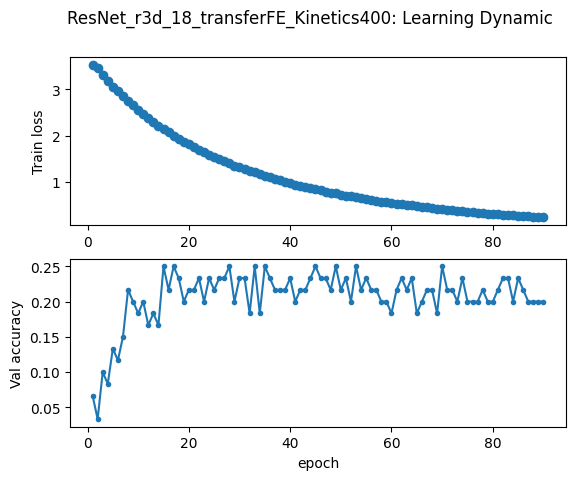

In [54]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [55]:
#best_acc = 1/n_class

previous_epochs = 90
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 91/105: train_loss=0.2235; val acc=0.233
Train Epoch 92/105: train_loss=0.2182; val acc=0.200
Train Epoch 93/105: train_loss=0.2113; val acc=0.217
Train Epoch 94/105: train_loss=0.205; val acc=0.167
Train Epoch 95/105: train_loss=0.202; val acc=0.217
Train Epoch 96/105: train_loss=0.1939; val acc=0.217
Train Epoch 97/105: train_loss=0.1895; val acc=0.200
Train Epoch 98/105: train_loss=0.1824; val acc=0.183
Train Epoch 99/105: train_loss=0.1796; val acc=0.200
Train Epoch 100/105: train_loss=0.1758; val acc=0.217
Train Epoch 101/105: train_loss=0.1698; val acc=0.233
Train Epoch 102/105: train_loss=0.1649; val acc=0.233
Train Epoch 103/105: train_loss=0.1599; val acc=0.200
Train Epoch 104/105: train_loss=0.1541; val acc=0.200
Train Epoch 105/105: train_loss=0.1518; val acc=0.200


In [56]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

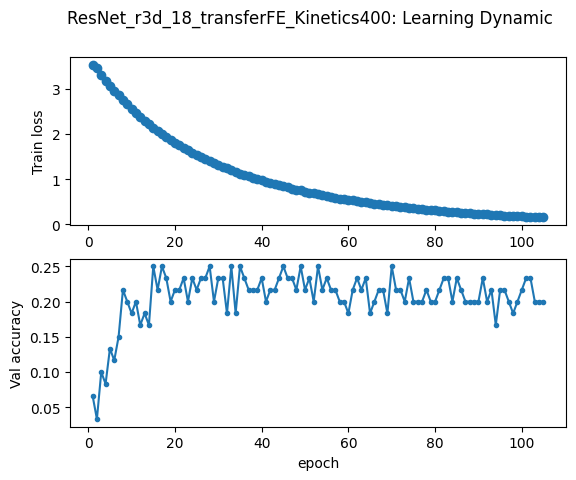

In [57]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [58]:
#best_acc = 1/n_class

previous_epochs = 105
num_epoches = 15

# if use_cuda:
#   model = torch.nn.DataParallel(resnet, device_ids=range(torch.cuda.device_count()))
#   cudnn.benchmark = True

# epochs = list()
# train_loss_dynamic = list()
# val_accuracy_dynamic = list()

for epoch in range(previous_epochs+1, previous_epochs + num_epoches + 1):
  epochs.append(epoch)
  print(f'Train Epoch {epoch}/{previous_epochs + num_epoches}', end=": ")
  train_loss = train_model(resnet, optimizer, criterion, train_dataloader, device, scheduler=None)
  print(f"train_loss={train_loss}", end="; ")
  train_loss_dynamic.append(train_loss)
  if epoch % 1 == 0:
    predict_acc, best_acc = validate_model(resnet, classes, epoch, criterion, optimizer, val_dataloader, device, best_acc, save, save_path, model_name)
    print(f"val acc={predict_acc:.3f}")
    val_accuracy_dynamic.append(predict_acc.item())
    save_model_dyn(save_path, model_name, train_loss_dynamic, val_accuracy_dynamic)

Train Epoch 106/120: train_loss=0.1465; val acc=0.200
Train Epoch 107/120: train_loss=0.1421; val acc=0.217
Train Epoch 108/120: train_loss=0.1377; val acc=0.217
Train Epoch 109/120: train_loss=0.1343; val acc=0.183
Train Epoch 110/120: train_loss=0.1313; val acc=0.200
Train Epoch 111/120: train_loss=0.1265; val acc=0.183
Train Epoch 112/120: train_loss=0.1243; val acc=0.217
Train Epoch 113/120: train_loss=0.1207; val acc=0.217
Train Epoch 114/120: train_loss=0.1166; val acc=0.200
Train Epoch 115/120: train_loss=0.1138; val acc=0.233
Train Epoch 116/120: train_loss=0.1103; val acc=0.217
Train Epoch 117/120: train_loss=0.1078; val acc=0.183
Train Epoch 118/120: train_loss=0.1042; val acc=0.233
Train Epoch 119/120: train_loss=0.1019; val acc=0.200
Train Epoch 120/120: train_loss=0.0999; val acc=0.200


In [59]:
torch.save({
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    'classes': classes
                },
                    f'{save_path}/{model_name}-{epoch}-Val_acc-{predict_acc:.3f}.pth')

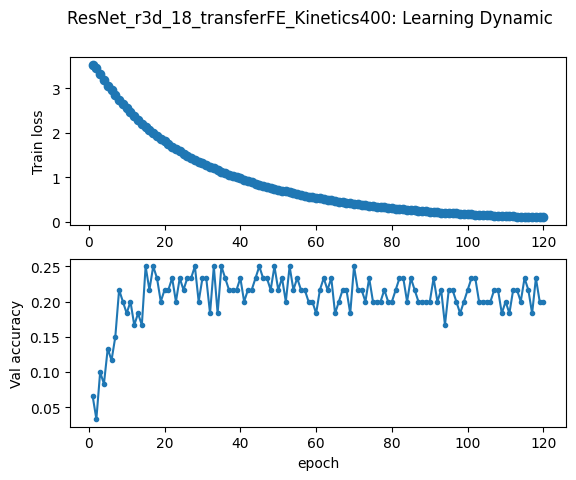

In [60]:
display_learning_dynamic(train_loss_dynamic, val_accuracy_dynamic, epochs, model_name)

In [ ]:
#classification_model_metrics(resnet, classes, test_dataloader, device)

In [ ]:
#classification_model_metrics(resnet, classes, val_dataloader, device)

In [ ]:
# Load best model state

# PATH = ""
# loaded_path = torch.load(PATH)
# model = torchvision.models.video.r3d_18()
# model.fc = nn.Linear(num_ftrs, n_class)
# model.load_state_dict(loaded_path['model_state_dict'])
# model.to(device)